# **<center>Sentiment Analysis | Amazon Reviews | LSTM | 95% Accuracy</center>**
---

# **<center>Steps</center>**

## **<center>[1. Load the dataset](#Step_1)</center>**

## **<center>[2. Data Exploration](#Step_2)</center>**

## **<center>[3. Text Cleaning and Dataset Shuffling](#Step_3)</center>**

## **<center>[4. Shuffling & Batching & Splitting](#Step_4)</center>**

## **<center>[5. Configure the datasets for performance](#Step_5)</center>**

## **<center>[6. Prepare the dataset for training](#Step_6)</center>**

## **<center>[7. Model Building and Training](#Step_7)</center>**
#### **<center>1. Sentiment Classifier without RNN Architecture</center>**
#### **<center>2. Bidirectional LSTM Sentiment Classifier</center>**

## **<center>[8. Model Evaluation](#Step_8)</center>**

## **<center>[9. Results Analysis](#Step_9)</center>**

---

## Importing dependencies

In [1]:
import tensorflow as tf
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import warnings
from tensorflow.keras import losses
warnings.filterwarnings("ignore")

In [35]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

---
<a id='Step_1'></a>
## **<center>1. Load the dataset</center>**

**`tf.data.TextLineDataset:`**

- We will use `tf.data.TextLineDataset` to load individual lines of text from the Amazon Reviews training and testing files.
- tf.data.TextLineDataset is designed to create a `tf.data.Dataset` from a text file where each example is a line of text from the original file. 

In [7]:
train_path = '/Users/drmorsy/Electro_pi/Deep Neural Networks Foundation/Amazon Reviews for Sentiment Analysis/train.ft.txt'
test_path = '/Users/drmorsy/Electro_pi/Deep Neural Networks Foundation/Amazon Reviews for Sentiment Analysis/test.ft.txt'

In [9]:
train_dataset = tf.data.TextLineDataset(
                                        train_path
                                        )

test_dataset = tf.data.TextLineDataset(
                                        test_path
                                        )

---
<a id='Step_2'></a>
## **<center>2. Data Exploration</center>**

#### **Inspect two random elements of the loaded dataset.**
    - To retrieve two random element from a tf.data.Dataset, we can use the shuffle() method to randomize the order and then take two element.

In [38]:
train_dataset = train_dataset.shuffle(buffer_size=1000)

In [39]:
train_dataset.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

In [40]:
i = 0
for line in train_dataset.take(3):
    if re.match(r'__label__2', line.numpy().decode('utf-8')):
        print(f"\nThis element represents an example of positive review:\n{55*'_'}\n{line.numpy().decode('utf-8')}\n")

    else:
        print(f"\nThis element represents an example of negative review:\n{55*'_'}\n{line.numpy().decode('utf-8')}\n")
    i+=1
    if i == 2:
        break


This element represents an example of negative review:
_______________________________________________________
__label__1 Wasnt worth: I bought a pink rubber squeem which had a seperate cotton cloth . That worked well, but i wonder why i dint buy the same and ended up with this. This product hurts me on my left hip and i got scars on my left hip.. :(


This element represents an example of negative review:
_______________________________________________________
__label__1 Not OK!!!: When I ordered this I thought it would allow me to wear some clothes that I haven't been able to do in a while because of my weight gain.I am a woman who has size 40D in breasts so I wear a large in tops and I wear a size 8 in pants, and weight 140lbs. It is suppose to clinch your waist and give you a nice looking figure. Well, it did hug my waist, but it also gave my a muffin top. Not a shape a woman wants to have. I looked better without wearing it. It folds into your folds creating a bigger fold at the 

#### **Explore the total number of elements in both the training and testing datasets.**

In [41]:
total_number_of_training_examples = sum([1 for element in train_dataset])
total_number_of_testing_examples = sum([1 for element in test_dataset])

print(f"\nTotal number of training examples is: {total_number_of_training_examples}\n")
print(f"\nTotal number of testing examples is: {total_number_of_testing_examples}\n")

2024-11-06 12:29:30.215671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



Total number of training examples is: 3600000


Total number of testing examples is: 400000



2024-11-06 12:29:39.867466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [42]:
train_dataset_percentage = (total_number_of_training_examples/(total_number_of_training_examples+total_number_of_testing_examples))*100
test_dataset_percentage = (total_number_of_testing_examples/(total_number_of_training_examples+total_number_of_testing_examples))*100

print(f"\nThe training dataset comprises {train_dataset_percentage}% of the entire dataset.\n")
print(f"\nThe testing dataset comprises {test_dataset_percentage}% of the entire dataset.\n")


The training dataset comprises 90.0% of the entire dataset.


The testing dataset comprises 10.0% of the entire dataset.



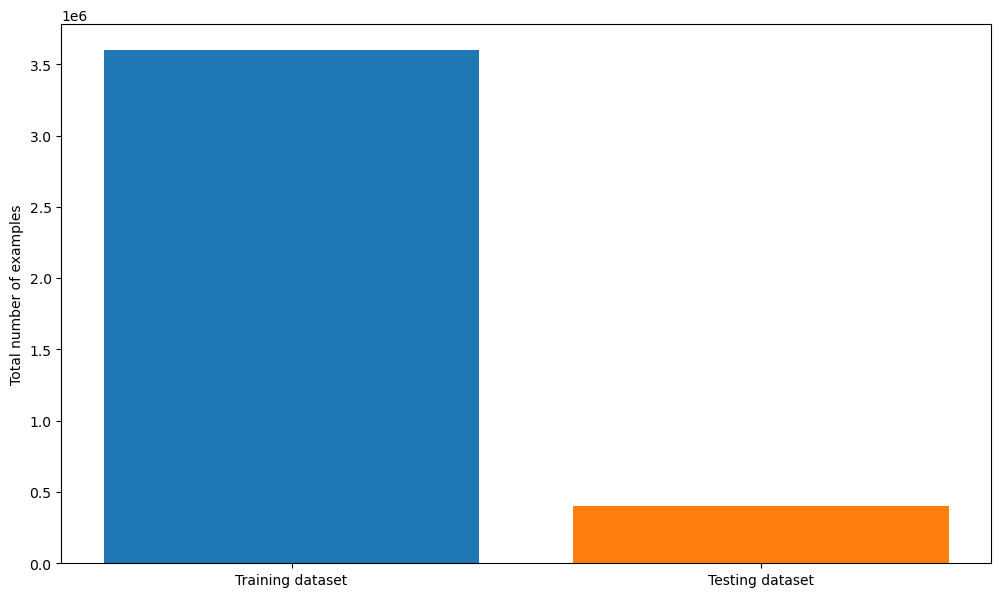

In [43]:
print(2*'\n')
fig, ax = plt.subplots(figsize=(12,7))
ax.bar('Training dataset', total_number_of_training_examples)
ax.bar('Testing dataset', total_number_of_testing_examples)
ax.set_ylabel('Total number of examples')
plt.show()
print(2*'\n')

#### **Findings from data exploration step**

- The training dataset contains 3.6 million Amazon customer reviews.
- The testing dataset contains 400,000 Amazon customer reviews.
- The training dataset represents 90.0% of the entire dataset.
- The testing dataset represents 10.0% of the entire dataset.
- There is no separate validation dataset; we will split the training dataset into a new training dataset and a validation dataset in the preprocessing step.
- Each element consists of a single component containing both the label and the text Amazon review:
    - **Class label:**
        - The line begins with the label __label__2, indicating that this review is a positive sentiment, associated with either a 4- or 5-star rating.
        - The line begins with the label __label__1, indicating that this review is a negative sentiment, associated with either a 1- or 2-star rating.
        - The classes are __label__1 and __label__2, and there is only one class per row.
        - Note: 3-star reviews i.e. reviews with neutral sentiment were not included 
    - **Text:** The review text follows the label.

---
<a id='Step_3'></a>
## **<center>3. Text Cleaning and Dataset Shuffling</center>**

#### **Splitting Dataset Elements into (Label, Text) Pairs**

- Split each element of the tf.data.Dataset to convert it from a single component containing both the label and the text review into two distinct components in the form of (text, label) pairs. In this transformation, positive examples are denoted by one, while negative examples are denoted by zero.

In [11]:
def extract_label(line):
    # Extract label from the line using regex
    label = tf.strings.regex_replace(line, r"^__label__(\d).*", r"\1")
    # Convert label to an integer
    label = tf.strings.to_number(label, out_type=tf.int32)
    if label == tf.cast(1, tf.int32):
        label = tf.cast(0, tf.int32)

    else:
        label = tf.cast(1, tf.int32)
    text = tf.strings.regex_replace(line, r'__label__\d', '')
    return text, label

In [13]:
train_dataset = train_dataset.map(extract_label)
test_dataset = test_dataset.map(extract_label)

In [46]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int32, name=None))

In [47]:
next(iter(train_dataset))

(<tf.Tensor: shape=(), dtype=string, numpy=b' Good read................. ............... .... ....... ........ .......... ......... ......... ......... ......... ..... .....: Good read................. ............... .... ....... ........ .......... ......... ......... ......... ......... ..... ..... ..... . . . . .. . . .'>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>)

#### **Display a preview of ten elements from the dataset after splitting them into (text, label) pairs.**

In [48]:
i = 0
for review, label in train_dataset.shuffle(buffer_size=100).take(6):
    print(f"\nLabel: {label.numpy()}")
    print(f"\nReview:{review.numpy().decode('utf-8')}\n")
    i += 1
    if i == 5:
        break


Label: 1

Review: The only boots my husband will wear: These boots are very well made. my husband wears them for work and he loves them. They hold up well even with every day wear, got a year+ out of the last pair. he also says they are very comfortable.


Label: 1

Review: One of her best in the Night World series!: Out of all L.J.Smiths works this is one of my most highly recommended. If you have read any other books in the Night World series you will have recognized Ash(one of the main characters), who seems to pop up in many scenes. The heroine Mary Lynette is also one of my favorite characters. During the entire novel she dosn't appear as shaken as most would after learning of the Night World,finding her soulmate vampire and befriending 3 rogue vampires. Even if this series is unrealistic what better kind of book to lose yourself in. I find the whole concept of the Night World,wild powers and soulmates fascinating,this book is worth it.


Label: 0

Review: Too simplistic: Althoug

#### **Text Preprocessing**

In [15]:
def clean_text(text, label):
    URLs = r'https?://\S+|www\.\S+'    
    html_tags = r'<.*?>' 
    text = tf.strings.regex_replace(text, URLs, '')
    text = tf.strings.regex_replace(text, html_tags, '')

    text = tf.strings.regex_replace(text, '[_-]', ' ')
    # Remove non-alphanumeric characters while preserving whitespace
    text = tf.strings.regex_replace(text, '[^a-zA-Z\s\d]', '')
    # Convert multiple whitespace characters to a single space
    text = tf.strings.regex_replace(text, '\s+', ' ')
    # Convert the text to lowercase
    text = tf.strings.lower(text)
    return text, label

In [17]:
train_dataset = train_dataset.map(clean_text)
test_dataset = test_dataset.map(clean_text)

In [51]:
i = 0 
for review, label in train_dataset.shuffle(buffer_size=100).take(6):
    print(f"\nLabel: {label.numpy()}")
    print(f"\nReview:{review.numpy().decode('utf-8')}\n")
    i += 1
    if i == 5:
        break


Label: 1

Review: fabulous this book was awesome a fast paced riveting novel by an author i am coming to find just cannot disappoint me i am hooked on her carpathians and now find that i will run just as fast to the bookstore when her next gothic comes outthe scarletti curse is a terrific love story and mystery set in a supposedly cursed castle that has everything from grinning gargoyles to an impressive maze the hero and heroine are just as riveting in their fascinatin for each other and then their entanglement in the mystery of the scarletti curse i highly recommend this book to all readers feehan fan or not but be warned by the time you turn the last page of this book you will be hooked on christine feehan


Label: 0

Review: totally unfunny when the film first started playing my partner and i looked at each other as if to say what on earth is this but we decided to give it a chance and let it play for about half an hour before we couldnt bare to watch any more the title says funny

In [52]:
total_num_of_negative_examples = 0
total_num_of_positive_examples = 0
for review, label in train_dataset:
    if label.numpy() == 0:
        total_num_of_negative_examples+=1
    elif label.numpy() == 1:
        total_num_of_positive_examples+=1

2024-11-06 12:33:21.529269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [53]:
print(f"\nTotal number of negative examples is: {total_num_of_negative_examples}\n")
print(f"\nTotal number of positive examples is: {total_num_of_positive_examples}\n")


Total number of negative examples is: 1800000


Total number of positive examples is: 1800000



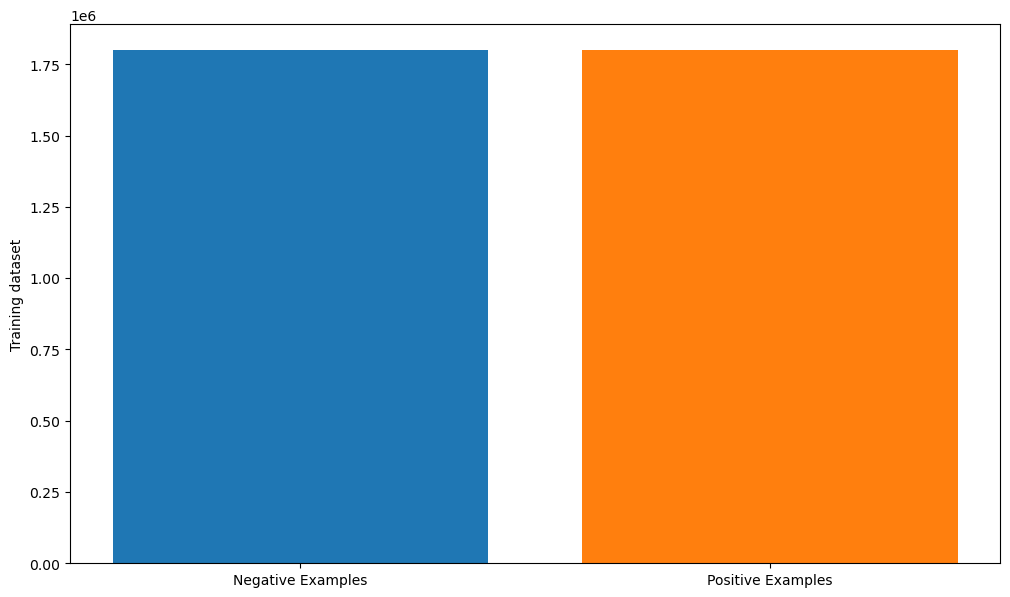

In [54]:
print(2*'\n')
fig, ax = plt.subplots(figsize=(12,7))
ax.bar('Negative Examples', total_num_of_negative_examples)
ax.bar('Positive Examples', total_num_of_positive_examples)
ax.set_ylabel('Training dataset')
plt.show()
print(2*'\n')

- **We have a balanced training dataset, with equal numbers of positive and negative examples, with 1,800,000 each.**

In [55]:
next(iter(train_dataset))

(<tf.Tensor: shape=(), dtype=string, numpy=b' amazingly good i came up to this book a reading assignment for school with a bit of dread having heard that hawthornes writing could be hard to read actually it was a delightful suprise to find it was a captivating plot very well written and very easy to read i enjoyed it thoroughly this book is about a woman who has an affair choosing to bear the scarlet letter than reveal her lovers identity along side her is her ilegitamate daughter a delightfully and hillariously strange character in the book the scarlet letter is a good book having a melancholy but redeeming ending a definate classic check it out itll be better than you expected'>,
 <tf.Tensor: shape=(), dtype=int32, numpy=1>)

- **The dataset is now cleaned and ready for the next step.**

---
<a id='Step_4'></a>
## **<center>4. Shuffling & Batching & Splitting</center>**

In [56]:
BUFFER_SIZE = 5000
BATCH_SIZE = 64
num_of_batches = int(total_number_of_training_examples/64)
num_of_batches

56250

#### **Dataset Shuffling**

In [21]:
train_dataset = train_dataset.shuffle(
                                    buffer_size=BUFFER_SIZE
                                    , reshuffle_each_iteration=False
                                    , seed = 123
                                     )
test_dataset = test_dataset.shuffle(
                                    buffer_size=BUFFER_SIZE
                                    , reshuffle_each_iteration=False
                                    , seed = 123
                                    )

#### **Dataset Batching**

In [23]:
train_dataset = train_dataset.batch(
                                    batch_size = BATCH_SIZE
                                    )
test_dataset = test_dataset.batch(
                                    batch_size = BATCH_SIZE
                                    )

#### **Splitting**

- **Create a validation dataset by transferring 20% of the batches from the training dataset into the validation dataset.**

In [25]:
train_data_set = train_dataset.take(int(num_of_batches*0.8))
val_data_set = train_dataset.skip(int(num_of_batches*0.8))

In [60]:
num_train_batches = sum(1 for _ in train_data_set)
num_val_batches = sum(1 for _ in val_data_set)

2024-11-06 12:34:18.590535: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-11-06 12:35:29.298188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [61]:
print('Number of training batches: %d' % num_train_batches)
print('Number of validation batches: %d' % num_val_batches)

Number of training batches: 45000
Number of validation batches: 11250


---
<a id='Step_5'></a>
## **<center>5. Configure the dataset for performance</center>**

**These are two important methods you should use when loading data to make sure that I/O does not become blocking.**
- Dataset.cache keeps data in memory after it's loaded off-disk. This will ensure the dataset does not become a bottleneck while training your model.
- Dataset.prefetch overlaps data preprocessing and model execution while training.

In [27]:
train_data_set = train_data_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_data_set = val_data_set.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

---
<a id='Step_6'></a>
## **<center>6. Prepare the dataset for training</center>**

- We will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.
- `Standardization` : refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset.
- `Tokenization` : refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace).
- `Vectorization` : refers to converting tokens into numbers so they can be fed into a neural network.

- We will set the output_mode to int to create unique integer indices for each token.
- We'll define some constants for the model, like an explicit maximum sequence_length, which will cause the layer to pad or truncate sequences to exactly sequence_length values.
- We'll set the Maximum size of the vocabulary.

In [29]:
VOCAB_SIZE = 10000
sequence_length = 200

encoder = layers.TextVectorization(
                                    max_tokens=VOCAB_SIZE,
                                    output_sequence_length=sequence_length,
                                    output_mode='int'
                                    )

- Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.
- It's important to only use your training data when calling adapt (using the test set would leak information).
- The .adapt method sets the layer's vocabulary.
- Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (Since a fixed output_sequence_length was not specified).

In [31]:
# Make a text-only dataset (without labels), then call adapt
train_text = train_data_set.map(lambda x, y: x)


In [33]:
encoder.adapt(train_text)

2024-11-06 23:11:48.343705: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [66]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(train_data_set))
first_review, first_label = text_batch[3], label_batch[3]
print("\nReview", first_review)
print("\nLabel", first_label.numpy())
print("\nVectorized review", encoder(first_review) , (first_label))


Review tf.Tensor(b' best introduction to its subject that i know of when one is trying to get a basic overall grasp of greek mythology it can be an overwhelming and formidable subject and one can be at a loss for the best place to start most books ive found either give too much detail too fast or else are hit and miss selections that dont give a very comprehensive introduction if thats been your experience too this book could be an excellent solution to your problem it gives a highly readable thorough introduction without overwhelming you with details as an introduction to or review of greek mythology it is therefore highly recommendable although probably aimed primarily at children i suppose grown ups too if not already expert on the subject wont find it too elementary', shape=(), dtype=string)

Label 1

Vectorized review tf.Tensor(
[  85 1228    6   35  744   13    4  121    7   51   25   10  306    6
   53    5  723  445 3803    7 3381 6335    8   60   26   42 4527    3
    1  744 

- As we can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [82]:
print("31 ---> ",encoder.get_vocabulary()[85])
print(" 747 ---> ",encoder.get_vocabulary()[1228])
print(" 1 ---> ",encoder.get_vocabulary()[1])
print('Vocabulary size: {}'.format(encoder.vocabulary_size()))

31 --->  best
 747 --->  introduction
 1 --->  [UNK]
Vocabulary size: 10000


---
<a id='Step_7'></a>
## **<center>7. Model Building and Training</center>**

#### **1. Text Classifier without RNN Architecture**

**Set the datasets to repeat indefinitely**

In [68]:
train_data_set = train_data_set.repeat()
val_data_set = val_data_set.repeat()
test_dataset = test_dataset.repeat()

In [141]:
simple_model = tf.keras.Sequential([encoder,
  layers.Embedding(VOCAB_SIZE, 64),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dense(64, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(1, activation='sigmoid')])

In [143]:
simple_model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [147]:
simple_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_4      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

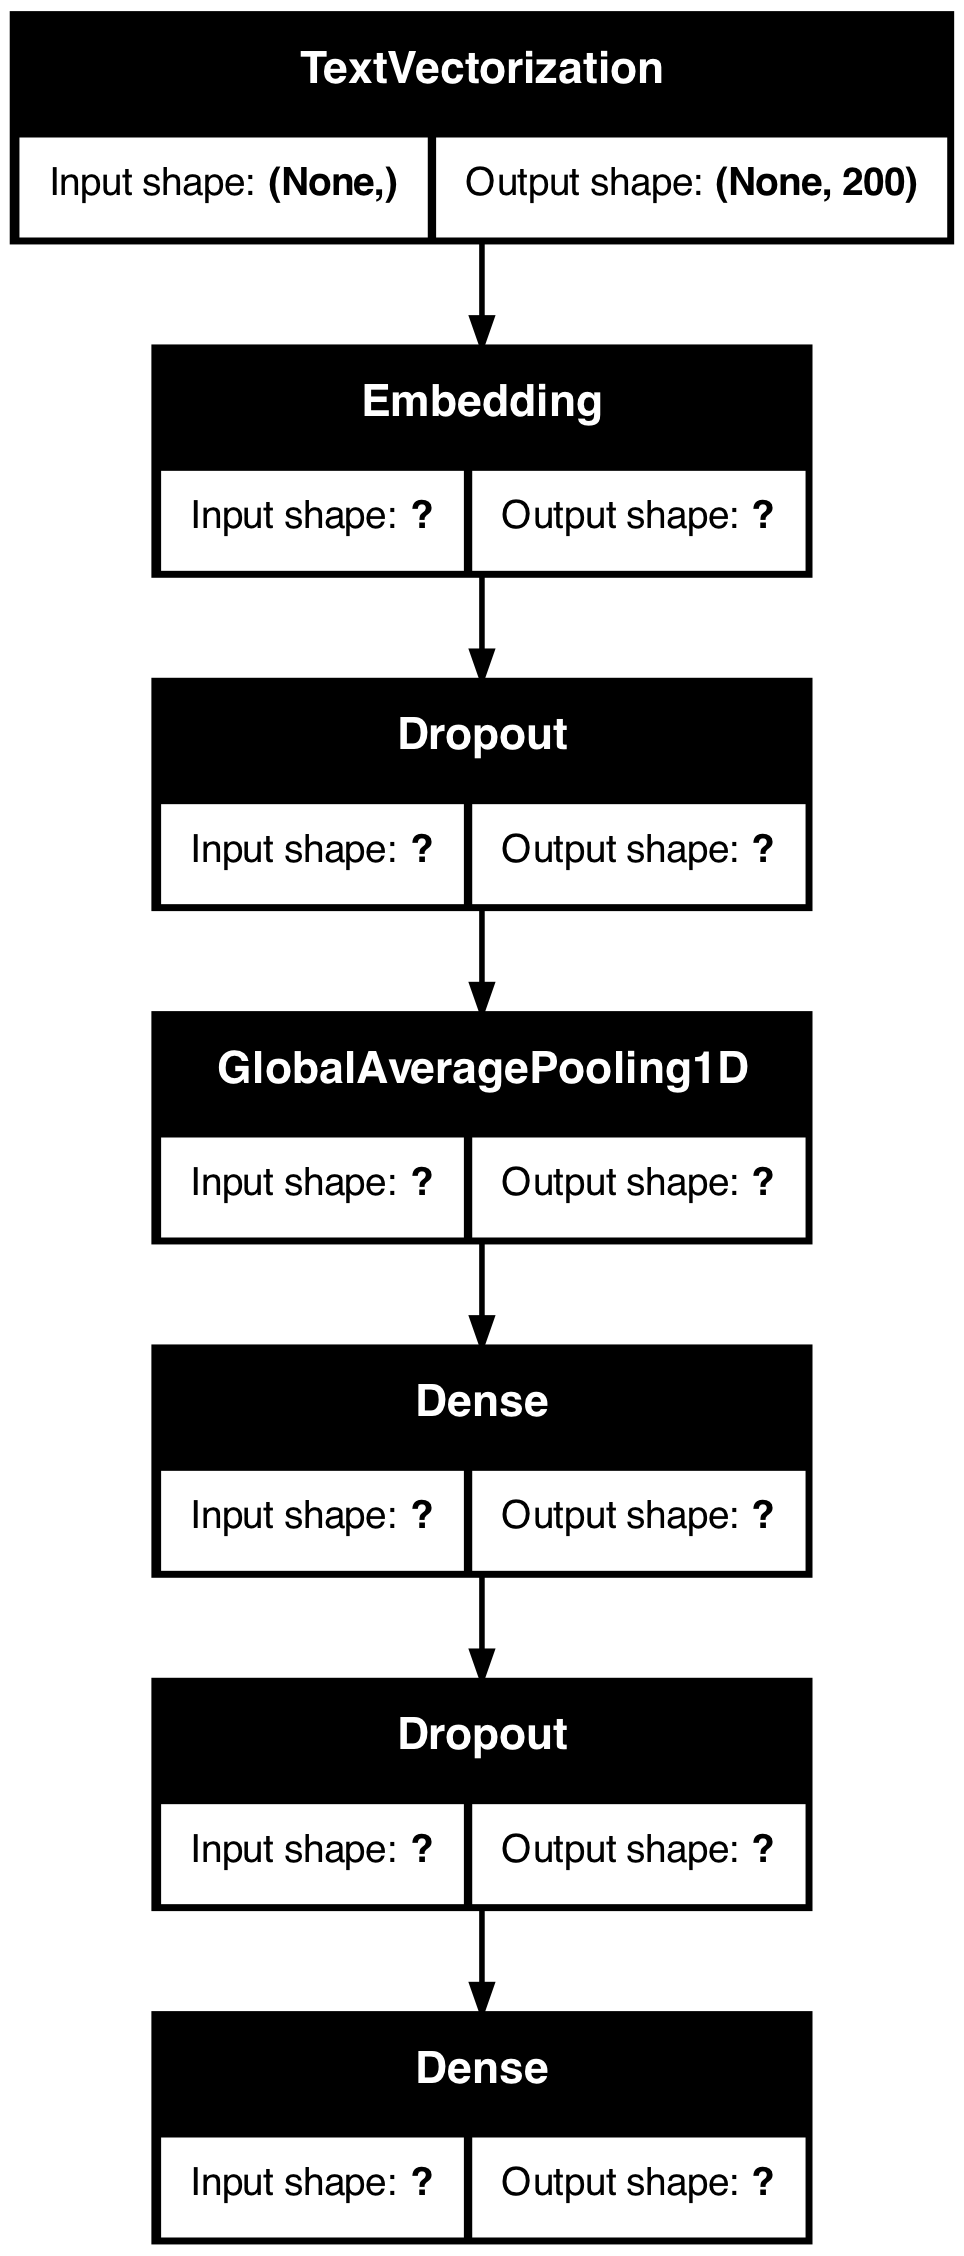

In [151]:
tf.keras.utils.plot_model(simple_model, show_shapes=True)

In [155]:
history_simple = simple_model.fit(train_data_set, epochs=3,
                    validation_data=val_data_set,
                    steps_per_epoch=num_train_batches,
                   validation_steps = num_val_batches)

Epoch 1/3
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 320s 7ms/step - binary_accuracy: 0.8749 - loss: 0.2890 - val_binary_accuracy: 0.8960 - val_loss: 0.2469
Epoch 2/3
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 327s 7ms/step - binary_accuracy: 0.9018 - loss: 0.2394 - val_binary_accuracy: 0.9019 - val_loss: 0.2355
Epoch 3/3
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 313s 7ms/step - binary_accuracy: 0.9061 - loss: 0.2314 - val_binary_accuracy: 0.9043 - val_loss: 0.2320


---

#### **2. Bidirectional LSTM Sentiment Classifier**

In [34]:
lstm_model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [35]:
lstm_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [36]:
lstm_model.build()

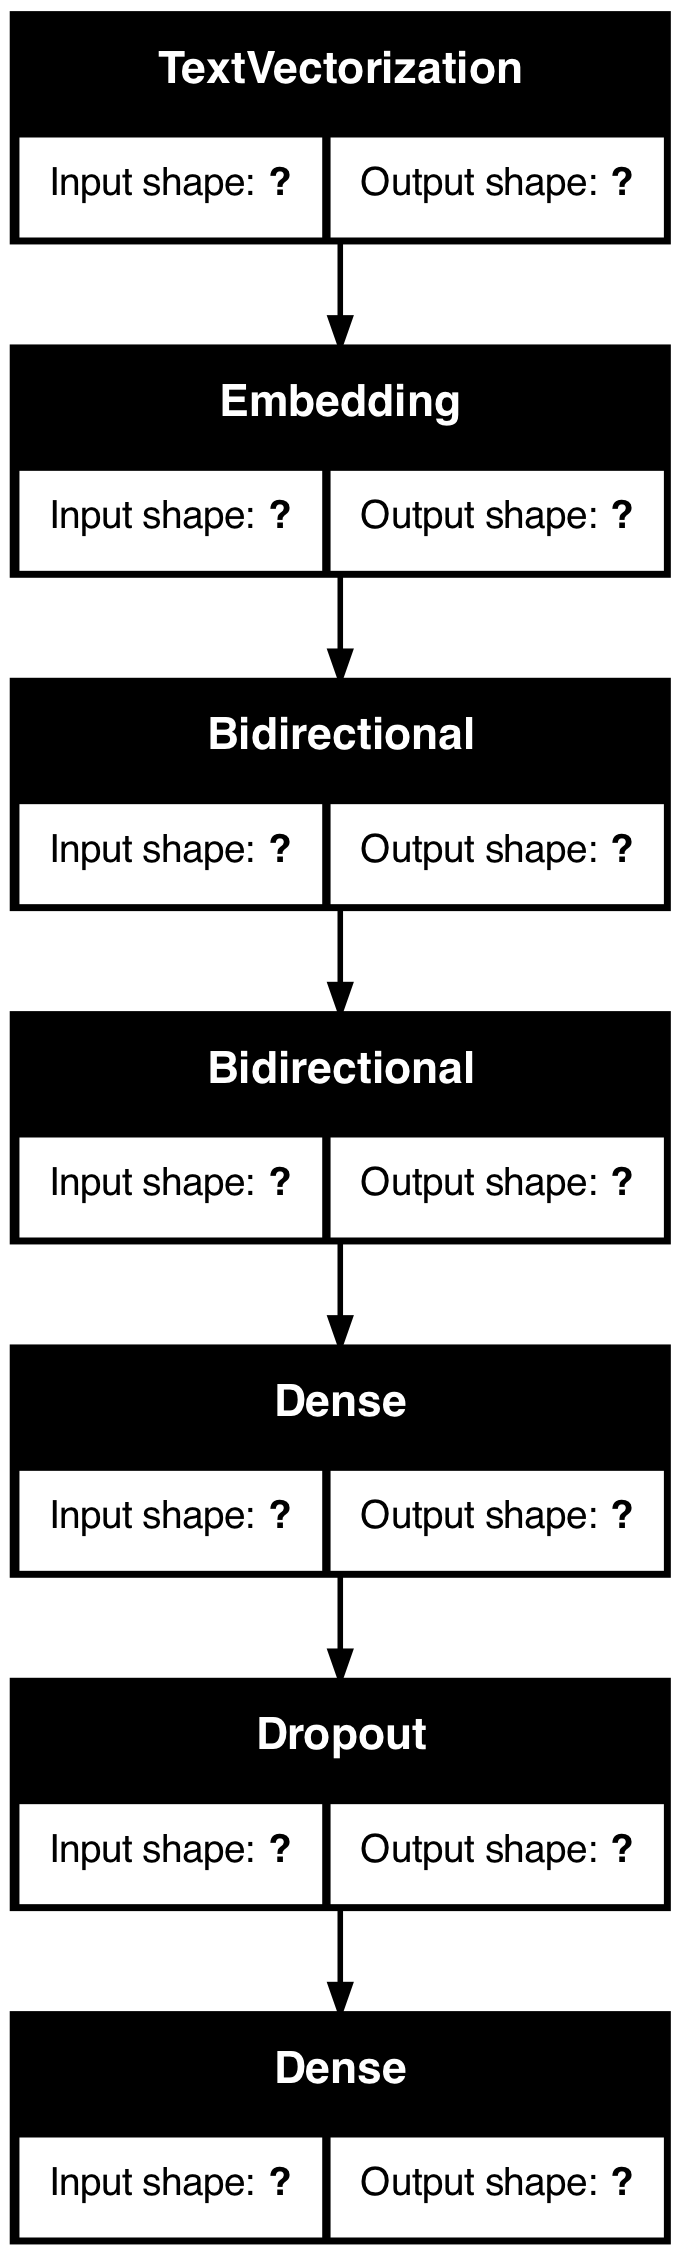

In [37]:
tf.keras.utils.plot_model(lstm_model, show_shapes=True)

In [76]:
history = lstm_model.fit(train_data_set, epochs=2,
                    validation_data=val_data_set,
                    steps_per_epoch=num_train_batches,
                   validation_steps = num_val_batches)

Epoch 1/2


2024-11-06 13:30:16.061268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


45000/45000 ━━━━━━━━━━━━━━━━━━━━ 12333s 274ms/step - binary_accuracy: 0.9200 - loss: 0.1945 - val_binary_accuracy: 0.9515 - val_loss: 0.1349
Epoch 2/2
45000/45000 ━━━━━━━━━━━━━━━━━━━━ 12464s 277ms/step - binary_accuracy: 0.9500 - loss: 0.1313 - val_binary_accuracy: 0.9547 - val_loss: 0.1285


- **Save the model**

In [86]:
lstm_model.save('lstm_model.keras')

---
<a id='Step_8'></a>
## **<center>8. Model Evaluation</center>**

In [78]:
loss, accuracy = lstm_model.evaluate(test_dataset, steps = 6250)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

6250/6250 ━━━━━━━━━━━━━━━━━━━━ 580s 93ms/step - binary_accuracy: 0.9518 - loss: 0.1366
Loss:  0.1321282684803009
Accuracy:  0.953202486038208


In [94]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

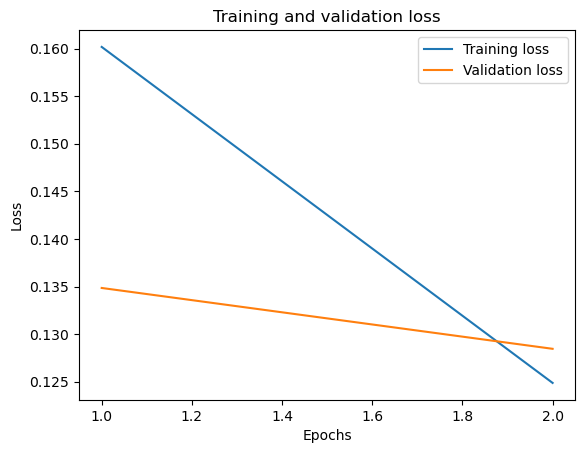

In [97]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

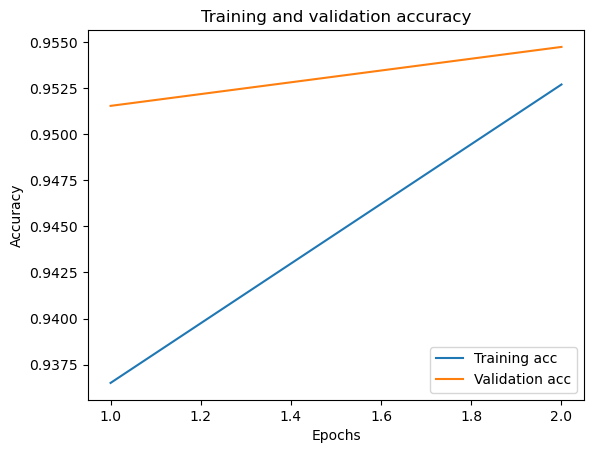

In [98]:
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

**Display a few examples along with their predictions**

In [124]:
y_pred = tf.sigmoid(lstm_model.predict(train_data_set.take(1)))
for text_batch,  label_batch in train_data_set.take(1):
    # Select a random index from the first batch
    for j in range(5):
        i = np.random.randint(0, 64)
        text , label = text_batch[i], label_batch[i]
        y_pred_i = 1 if y_pred[i][0].numpy()>.5 else 0
        print("\nReview", text)
        print("\nLabel", label.numpy())
        print("\nPredicted label",y_pred_i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step

Review tf.Tensor(b' sandisk sansa view player mp3 player plays less than two hours while advertised as eight hours of play time the player didnt make a two hour trip once in the three or four weeks we had itnow just waiting to get the refund weve been notified we will receive so we can try something else hopefully something that will live up to its advertisement this time', shape=(), dtype=string)

Label 0

Predicted label 0

Review tf.Tensor(b' if you think metallica is kiddie music this album is sweet i originally bought it just to listen to tubthumper but by now that has become my least favorite song one of the postive aspects of the cd is the constantly changing tempo of each song the many different styles and tempos in each song and the fact that the songs have some meaning make it all the more worthwhile buy this cd you will find yourself headbanging to every song on this album in no time', shape=(), dtype=string)

Label 1

Predicted label 

2024-11-06 22:44:21.590162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


---
<a id='Step_9'></a>
## **<center>9. Results Analysis</center>**

- The application of the Long Short-Term Memory (LSTM) architecture has led to a significant performance improvement over simpler models.
-  LSTM model demonstrated consistent enhancement with each epoch, highlighting its ability to better capture sequential patterns and long-term dependencies.
-  The LSTM model achieved an impressive 95% accuracy across the training, testing, and validation datasets, a notable improvement compared to the simpler model. This demonstrates the effectiveness of LSTM in understanding complex sequences and ensuring better generalization across different data splits.
-  While the LSTM model shows promising results, further fine-tuning could enhance its performance even more. Consider experimenting with hyperparameters such as the number of LSTM units, learning rate, and dropout rates to optimize the model.
- Additionally, leveraging transfer learning with pre-trained word embeddings (e.g., GloVe or Word2Vec) could provide richer semantic representations, further boosting model accuracy.
- The next step is to explore Transformers, which can significantly improve performance by leveraging self-attention mechanisms to capture global dependencies in the data.

# **<center>THANKS</center>**